<a href="https://colab.research.google.com/github/basho-nguyen/Finnal_DA_Project/blob/main/Finnall_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. ETL PROCESS

Import các thư viện cần thiết trong quá trình xử lý dữ liệu, visualize

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sqlalchemy import create_engine
!pip install pymysql
import pymysql

Load data từ file exel vào data frame

In [2]:
campaigns = pd.read_excel('advertising-data.xlsx', sheet_name='Campaigns')
ads = pd.read_excel('advertising-data.xlsx', sheet_name='Ad')
metrics = pd.read_excel('advertising-data.xlsx', sheet_name='Metrics')
targets = pd.read_excel('advertising-data.xlsx', sheet_name='Targets')





Kiểm tra dữ liệu


In [3]:
campaigns.info()
ads.info()
metrics.info()
targets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Campaign ID          41 non-null     object        
 1   Channel              41 non-null     object        
 2   Campaign Name        41 non-null     object        
 3   Campaign time start  41 non-null     datetime64[ns]
 4   Campaign time end    41 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 1.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Ad ID        168 non-null    int64 
 1   Campaign ID  168 non-null    object
 2   Type         168 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data colu

Audit type of data

*   Campaign ID: object -> string
*   Gender -> category
*   Campaign name -> string
*   Type -> category
*   Channel -> category









In [21]:
campaigns['Campaign ID'] = campaigns['Campaign ID'].astype('string')
campaigns['Campaign Name'] = campaigns['Campaign Name'].astype('string')
campaigns['Channel'] = campaigns['Channel'].astype('category')

ads['Campaign ID'] = ads['Campaign ID'].astype('string')
ads['Type'] = ads['Type'].astype('category')
ads['Ad ID'] = ads['Ad ID'].astype('string')


metrics['Metric ID'] = metrics['Metric ID'].astype('string')
metrics['Ad ID'] = metrics['Ad ID'].astype('string')

targets['Campaign ID'] = targets['Campaign ID'].astype('string')
targets['Gender'] = targets['Gender'].astype('category')
targets['Age'] = targets['Age'].astype('string')
targets['Ad Set ID'] =  targets['Ad Set ID'].astype('string')



Với bảng Metrics
Cần thêm trường CTR, CPC


In [22]:
metrics['Avg CTR'] = metrics['Clicks'] / metrics['Impressions']*100
metrics['Avg CTR'].replace(np.inf, np.nan, inplace=True)
metrics['Avg CPC'] = metrics['Spend'] / metrics['Clicks']
metrics['Avg CPC'].replace(np.inf, np.nan, inplace=True)
metrics['CR'] = metrics['Lead'] / metrics['Clicks']
metrics['CR'].replace(np.inf, np.nan, inplace=True)

Check lại data

In [23]:
metrics.head(10)
metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Metric ID    716 non-null    string        
 1   Ad ID        716 non-null    string        
 2   Day          716 non-null    datetime64[ns]
 3   Spend        716 non-null    float64       
 4   Impressions  716 non-null    int64         
 5   Average CPM  716 non-null    float64       
 6   Clicks       716 non-null    float64       
 7   Lead         716 non-null    float64       
 8   CPL          716 non-null    float64       
 9   Avg CTR      637 non-null    float64       
 10  Avg CPC      527 non-null    float64       
 11  CR           527 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(1), string(2)
memory usage: 67.2 KB


Các trường CPL khi ko có lead sẽ phát sinh ra kiểu dữ liệu NaN
->Fill NaN =  giá trị 0

In [24]:
metrics = metrics.fillna(0)

Kiểm tra Outlier data

In [25]:
metrics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Metric ID    716 non-null    string        
 1   Ad ID        716 non-null    string        
 2   Day          716 non-null    datetime64[ns]
 3   Spend        716 non-null    float64       
 4   Impressions  716 non-null    int64         
 5   Average CPM  716 non-null    float64       
 6   Clicks       716 non-null    float64       
 7   Lead         716 non-null    float64       
 8   CPL          716 non-null    float64       
 9   Avg CTR      716 non-null    float64       
 10  Avg CPC      716 non-null    float64       
 11  CR           716 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(1), string(2)
memory usage: 67.2 KB


Lưu dữ liệu đã được xử lý vào data warehouse


In [ ]:
db_path = 'data_warehouse.db'
warehouse_engine = create_engine(f'sqlite:///{db_path}')
campaigns.to_sql('Campaign', con=warehouse_engine, if_exists='replace', index=False)
targets.to_sql('Target', con=warehouse_engine, if_exists='replace', index=False)
ads.to_sql('Ad', con=warehouse_engine, if_exists='replace', index=False)
metrics.to_sql('Metrics', con=warehouse_engine, if_exists='replace', index=False)

# **II. Correlation calculation**

Lọc ra các trường là dữ liệu số

In [26]:
# Select only numeric columns
numeric_cols = metrics.select_dtypes(include=[np.number]).columns.tolist()
num_metrics = metrics[numeric_cols]

# Calculate correlation
metrics_corr = metrics[numeric_cols].corr()
metrics_corr

,Spend,Impressions,Average CPM,Clicks,Lead,CPL,Avg CTR,Avg CPC,CR
Spend,1.000000,0.126443,0.319872,0.154857,0.475879,0.633612,0.157757,0.258147,0.197897
Impressions,0.126443,1.000000,-0.123579,0.330900,-0.061394,-0.032331,-0.097873,-0.124874,-0.067431
Average CPM,0.319872,-0.123579,1.000000,-0.099886,0.362853,0.139004,0.614853,0.179944,0.175214
Clicks,0.154857,0.330900,-0.099886,1.000000,-0.022500,-0.015095,0.292158,-0.228864,-0.081864
Lead,0.475879,-0.061394,0.362853,-0.022500,1.000000,0.443906,0.339019,0.067148,0.571746
CPL,0.633612,-0.032331,0.139004,-0.015095,0.443906,1.000000,0.061042,0.107309,0.325034
Avg CTR,0.157757,-0.097873,0.614853,0.292158,0.339019,0.061042,1.000000,-0.111212,0.124133
Avg CPC,0.258147,-0.124874,0.179944,-0.228864,0.067148,0.107309,-0.111212,1.000000,0.222571
CR,0.197897,-0.067431,0.175214,-0.081864,0.571746,0.325034,0.124133,0.222571,1.000000


Hãy xem các mỗi liên hệ giữa các cặp data trong data frame 'metrics'

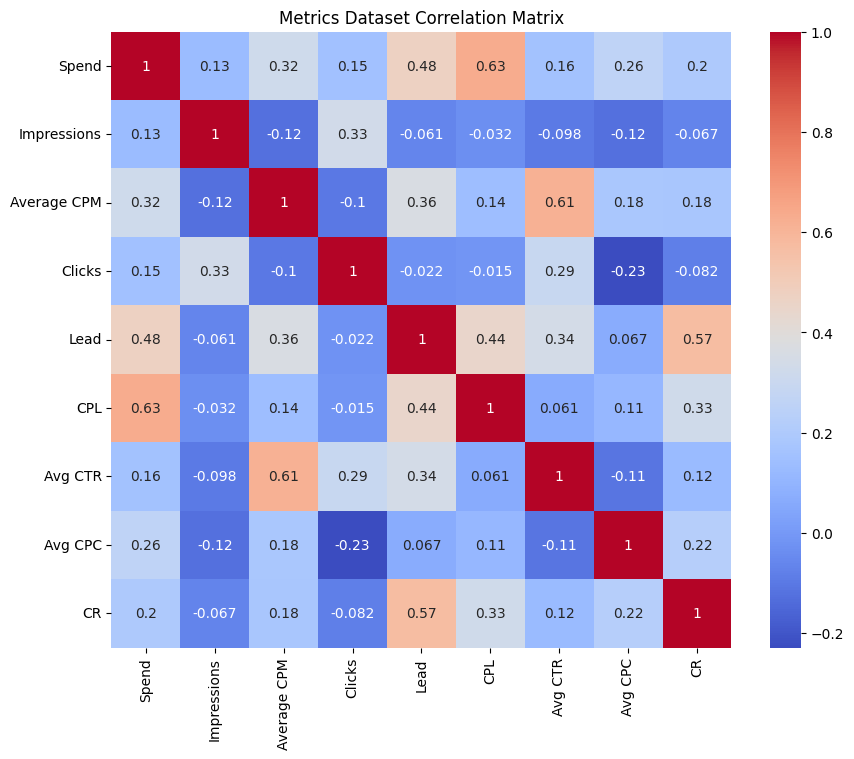

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(metrics_corr, annot=True, cmap='coolwarm')
plt.title('Metrics Dataset Correlation Matrix')
plt.show()

Dựa trên ma trận tương quan bạn cung cấp, đây là phân tích chi tiết về mối quan hệ giữa các chỉ số quảng cáo khác nhau:

**1. Chi tiêu vs CPL (Chi phí mỗi khách hàng tiềm năng)**
Tương quan: 0.63
Phân tích: Có mối tương quan tích cực mạnh, cho thấy khi chi tiêu tăng lên, chi phí mỗi khách hàng tiềm năng cũng có xu hướng tăng. Điều này cho thấy việc tăng chi tiêu có thể tạo ra nhiều khách hàng tiềm năng hơn nhưng chi phí để thu hút mỗi khách hàng lại cao hơn.

**2. Chi tiêu vs Số khách hàng tiềm năng**
Tương quan: 0.48
Phân tích: Mối tương quan tích cực vừa phải cho thấy việc tăng chi tiêu thường dẫn đến sự tăng lên của số khách hàng tiềm năng được tạo ra, điều này là dễ hiểu trong hầu hết các kịch bản quảng cáo.

**3. Số lượt nhấp vs Số khách hàng tiềm năng**
Tương quan: -0.022
Phân tích: Có mối tương quan tiêu cực rất yếu, cho thấy hầu như không có mối quan hệ trực tiếp nào giữa số lượt nhấp và số khách hàng tiềm năng. Điều này có thể ngụ ý rằng mặc dù các lượt nhấp được tạo ra, nhưng chúng có thể không hiệu quả trong việc chuyển đổi thành khách hàng tiềm năng.

**4. CPM trung bình (Chi phí mỗi ngàn lượt hiển thị) vs CPC trung bình (Chi phí mỗi lượt nhấp)**
Tương quan: 0.61
Phân tích: Có mối tương quan tích cực mạnh, cho thấy các chiến dịch có chi phí cao hơn cho mỗi ngàn lượt hiển thị cũng có xu hướng có chi phí cao hơn cho mỗi lượt nhấp. Điều này hợp lý vì cả hai chỉ số đều liên quan đến hiệu quả chi phí của chiến dịch.

**5. Số khách hàng tiềm năng vs Tỷ lệ chuyển đổi (CR)**
Tương quan: 0.57
Phân tích: Một mối tương quan tích cực mạnh cho thấy việc tăng số lượng khách hàng tiềm năng thường tương ứng với tỷ lệ chuyển đổi cao hơn. Điều này có thể ngụ ý rằng việc nhắm mục tiêu hiệu quả hơn hoặc thu hút khách hàng tiềm năng chất lượng cao hơn đã được thực hiện, dẫn đến tỷ lệ chuyển đổi tốt hơn.

**6. Số lượt hiển thị vs Số lượt nhấp**
Tương quan: 0.33
Phân tích: Mối tương quan tích cực vừa phải, điều này là dễ hiểu vì nhiều lượt hiển thị thường tạo ra nhiều cơ hội để nhận được lượt nhấp, mặc dù mối tương quan không mạnh lắm, cho thấy không phải tất cả các lượt hiển thị đều dẫn đến lượt nhấp.

**7. Tỷ lệ nhấp trung bình (CTR) vs Tỷ lệ chuyển đổi (CR)**
Tương quan: 0.12
Phân tích: Mối tương quan tích cực yếu cho thấy tỷ lệ nhấp cao hơn chỉ góp phần nhỏ vào việc cải thiện tỷ lệ chuyển đổi. Điều này cho thấy trong khi CTR quan trọng, nhưng nó không phải là yếu tố duy nhất ảnh hưởng đến chuyển đổi.

**8. CPM trung bình vs Số lượt hiển thị**
Tương quan: -0.12
Phân tích: Mối tương quan tiêu cực yếu này cho thấy khi chi phí mỗi ngàn lượt hiển thị giảm, số lượt hiển thị có thể tăng lên một chút. Điều này có thể ngụ ý hiệu quả ngân sách tốt hơn trong việc tiếp cận đối tượng lớn hơn với chi phí thấp hơn.

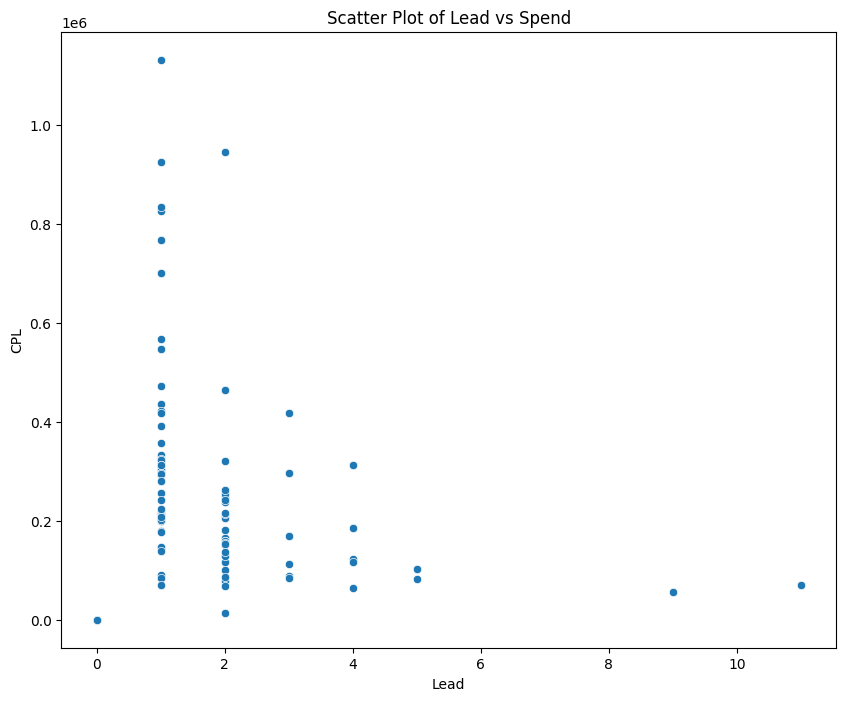

In [30]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=metrics, x='Lead', y='CPL')
plt.xlabel('Lead')
plt.ylabel('CPL')

plt.title('Scatter Plot of Lead vs Spend')
plt.show()

# **III.  Linear regression & Prediction**

## Multiple Linear Regression
**Dự đoán số lượng Lead dựa vào ads spend, clicks, avg CTR, CR **

In [43]:
x = metrics[['Spend','Clicks','Avg CTR','CR']]
y = metrics['Lead']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Lead   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     196.4
Date:                Sun, 30 Jun 2024   Prob (F-statistic):          2.25e-113
Time:                        15:14:41   Log-Likelihood:                -626.78
No. Observations:                 716   AIC:                             1264.
Df Residuals:                     711   BIC:                             1286.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1662      0.030     -5.547      0.0

Dựa trên kết quả hồi quy OLS được cung cấp, chúng ta sẽ đánh giá các chỉ số liên quan tới biến phụ thuộc Lead. Dưới đây là phân tích chi tiết:

**R-squared và Adjusted R-squared**
*R-squared: 0.525. *
Điều này có nghĩa là mô hình giải thích được 52.5% biến thiên của biến phụ thuộc Lead.

*Adjusted R-squared: 0.522.*
Giá trị này điều chỉnh cho số lượng biến độc lập trong mô hình. 52.2% vẫn là một mức độ giải thích khá tốt.

**Các hệ số hồi quy (Coefficients)**
Dưới đây là các hệ số ước lượng, cùng với giá trị t và p-value tương ứng:

**const (Intercept): -0.1662**
t-value: -5.547
P>|t|: 0.000
Giá trị p-value rất nhỏ cho thấy hệ số intercept có ý nghĩa thống kê.

**Spend: 1.58e-06**
t-value: 13.477
P>|t|: 0.000
Giá trị p-value rất nhỏ, cho thấy biến Spend có ý nghĩa thống kê trong việc dự đoán Lead.

**Clicks: -0.0017**
t-value: -4.245
P>|t|: 0.000
Giá trị p-value rất nhỏ, cho thấy biến Clicks có ý nghĩa thống kê trong việc dự đoán Lead.

**Avg CTR: 0.0761**
t-value: 9.432
P>|t|: 0.000
Giá trị p-value rất nhỏ, cho thấy biến Avg CTR có ý nghĩa thống kê trong việc dự đoán Lead.

**CR: 4.6363**
t-value: 17.107
P>|t|: 0.000
Giá trị p-value rất nhỏ, cho thấy biến CR có ý nghĩa thống kê trong việc dự đoán Lead.



***Kết luận, mô hình này có một số hạn chế như R-squared thấp, dư lượng không tuân theo phân phối chuẩn, và vấn đề đa cộng tuyến, cho thấy cần cải tiến mô hình hoặc xem xét thêm các yếu tố khác có thể ảnh hưởng đến số khách hàng tiềm năng như: content, target audience, các yếu tố thị trường, nhu cầu, ads platform,...**


## Predictation

Tạo data set predict


In [50]:
# Định nghĩa số lượng mẫu dữ liệu
num_samples = 10

# Tạo dữ liệu giả định cho các biến
np.random.seed(0)  # Để kết quả ngẫu nhiên có thể tái lập
data = {
    'Spend': np.random.normal(1000000, 10000000, num_samples),  # Giả định chi tiêu trung bình 10000 với độ lệch chuẩn 2000
    'Clicks': np.random.normal(200, 50, num_samples),  # Giả định số lần click trung bình 200 với độ lệch chuẩn 50
    'Avg CTR': np.random.normal(0.05, 0.01, num_samples),  # Giả định tỷ lệ nhấp chuột trung bình 0.05 với độ lệch chuẩn 0.01
    'CR': np.random.normal(0.001, 0.002, num_samples),  # Giả định tỷ lệ chuyển đổi trung bình 0.1 với độ lệch chuẩn 0.02
    'Lead': np.random.normal(50, 10, num_samples)  # Giả định số lượng lead trung bình 50 với độ lệch chuẩn 10
}

# Tạo DataFrame
new_data = pd.DataFrame(data)

In [51]:
predictions = model.predict(new_data)

In [58]:
print(predictions)

0   -3.097006e+06
1   -8.308630e+05
2   -1.792209e+06
3   -3.889155e+06
4   -3.268959e+06
5    1.457840e+06
6   -1.744585e+06
7    8.559968e+04
8    5.505226e+03
9   -8.481556e+05
dtype: float64


Mô hình hồi quy đang tạo ra các giá trị dự đoán Lead không hợp lý (bao gồm các giá trị âm và rất lớn). Điều này chỉ ra rằng mô hình dự đoán chưa đủ tính chính xác.